#**Fetch Dataset from Kaggle**

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d omkarmanohardalvi/lungs-disease-dataset-4-types

Dataset URL: https://www.kaggle.com/datasets/omkarmanohardalvi/lungs-disease-dataset-4-types
License(s): unknown


In [ ]:
!unzip lungs-disease-dataset-4-types.zip

Streaming output truncated to the last 5000 lines.
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0673-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0675-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0678-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0680-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0682-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0683-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0684-0001-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0686-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0690-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0692-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0693-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0695-0001.jpeg  
  inflating: Lung Disease Dataset/train/Norm

#**Initial model with 80% accuracy**

### **Step 1: Import Libraries**

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

### **Step 2: Paths and Parameters**

In [ ]:
base_dir = '/content/Lung Disease Dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

### **Step 3: Define parameters**

In [ ]:
# Step 4: MODIFIED - Create SIMPLE data generators (no augmentation)
IMG_SIZE = (224, 224)  # Standard size for many CNN models
BATCH_SIZE = 32
EPOCHS = 30

### **Step 4: Create SIMPLE data generators (no augmentation)**
*Since data is already augmented, we only need rescaling*

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

### **Step 5: Create data generators**

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

Found 6054 images belonging to 5 classes.
Found 2016 images belonging to 5 classes.
Found 2025 images belonging to 5 classes.


### **Step 6: Verify class labels**

In [ ]:
NUM_CLASSES = len(train_generator.class_indices)
print(f"Number of classes detected: {NUM_CLASSES}")
print("Class names:", list(train_generator.class_indices.keys()))

Number of classes detected: 5
Class names: ['Bacterial Pneumonia', 'Corona Virus Disease', 'Normal', 'Tuberculosis', 'Viral Pneumonia']


### **Step 7: Build a CNN model**

In [ ]:
def create_model():
    model = Sequential([
        # First Conv Block
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), padding='same'),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),

        # Second Conv Block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        # Third Conv Block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.4),

        # Classifier
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')  # Now using the correct number of classes
    ])
    return model

model = create_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 25,981,477 (99.11 MB)

 Trainable params: 25,980,069 (99.11 MB)

 Non-trainable params: 1,408 (5.50 KB)

### **Step 8: Compile the model with lower learning rate**

In [ ]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### **Step 9: Define aggressive callbacks**

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

### **Step 10: Train the model**

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30


I0000 00:00:1745836078.838367     111 service.cc:148] XLA service 0x79a150007e20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745836078.840262     111 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745836078.840288     111 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745836079.650385     111 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/189 ━━━━━━━━━━━━━━━━━━━━ 1:31:44 29s/step - accuracy: 0.1562 - loss: 2.9429

I0000 00:00:1745836097.199484     111 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


189/189 ━━━━━━━━━━━━━━━━━━━━ 150s 643ms/step - accuracy: 0.6600 - loss: 1.0021 - val_accuracy: 0.2014 - val_loss: 12.0141 - learning_rate: 1.0000e-04
Epoch 2/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 155us/step - accuracy: 0.8125 - loss: 0.7663 - learning_rate: 1.0000e-04
Epoch 3/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 71s 364ms/step - accuracy: 0.7765 - loss: 0.5653 - val_accuracy: 0.3686 - val_loss: 6.7477 - learning_rate: 1.0000e-04
Epoch 4/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 130us/step - accuracy: 0.8125 - loss: 0.4244 - learning_rate: 1.0000e-04
Epoch 5/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 69s 356ms/step - accuracy: 0.8040 - loss: 0.4895 - val_accuracy: 0.5114 - val_loss: 1.7531 - learning_rate: 1.0000e-04
Epoch 6/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 117us/step - accuracy: 0.7188 - loss: 0.5767 - learning_rate: 1.0000e-04
Epoch 7/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 68s 351ms/step - accuracy: 0.8351 - loss: 0.4163 - val_accuracy: 0.5645 - val_loss: 1.3747 - learning_rate: 1.0000e-04
Epoch 8/30
189/189 ━━━━━━

### **Step 11: Evaluate the model on test set**

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc*100:.2f}%")

64/64 ━━━━━━━━━━━━━━━━━━━━ 30s 467ms/step - accuracy: 0.7772 - loss: 0.5620
Test Accuracy: 80.69%


### **Step 12: Plot training history**

In [ ]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

In [ ]:
class_names=train_generator.class_indices.keys()
# Get predictions
test_generator.reset()
y_pred = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + 1)
y_pred = np.argmax(y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#**Enhanced Approach: Used Ensemble of EfficientNetB3 and DenseNet121**

### **Step 1: Import Required Libraries**

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB3, ResNet50V2, DenseNet121
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

### **Step 2: Set Constants and Seed for Reproducibility**

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

### **Step 3: Define Constants and Configuration**

In [ ]:
BASE_DIR = '/content/Lung Disease Dataset'
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 50
NUM_CLASSES = 5

###**Step 4: Check GPU Availability**

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


###**Step 5: Set Up Data Paths**

In [ ]:
train_dir = os.path.join(BASE_DIR, 'train')
val_dir = os.path.join(BASE_DIR, 'val')
test_dir = os.path.join(BASE_DIR, 'test')

### **Step 6: Dataset Exploration and Visualization**

In [ ]:
def display_dataset_info(base_dir):
    print(f"Dataset directory: {base_dir}")
    class_names = os.listdir(base_dir)
    for class_name in class_names:
        class_dir = os.path.join(base_dir, class_name)
        if os.path.isdir(class_dir):
            num_images = len(os.listdir(class_dir))
            print(f"Class: {class_name}, Number of images: {num_images}")

print("Training dataset:")
display_dataset_info(train_dir)
print("\nValidation dataset:")
display_dataset_info(val_dir)
print("\nTest dataset:")
display_dataset_info(test_dir)

Training dataset:
Dataset directory: /content/Lung Disease Dataset/train
Class: Corona Virus Disease, Number of images: 1218
Class: Normal, Number of images: 1207
Class: Tuberculosis, Number of images: 1220
Class: Viral Pneumonia, Number of images: 1204
Class: Bacterial Pneumonia, Number of images: 1205

Validation dataset:
Dataset directory: /content/Lung Disease Dataset/val
Class: Corona Virus Disease, Number of images: 406
Class: Normal, Number of images: 402
Class: Tuberculosis, Number of images: 406
Class: Viral Pneumonia, Number of images: 401
Class: Bacterial Pneumonia, Number of images: 401

Test dataset:
Dataset directory: /content/Lung Disease Dataset/test
Class: Corona Virus Disease, Number of images: 407
Class: Normal, Number of images: 404
Class: Tuberculosis, Number of images: 408
Class: Viral Pneumonia, Number of images: 403
Class: Bacterial Pneumonia, Number of images: 403


###**Step 7: Data Augmentation and Preprocessing**

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

###**Step 8: Data Loading with Generators**

In [ ]:
def load_data():
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )

    validation_generator = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    test_generator = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, validation_generator, test_generator

train_generator, validation_generator, test_generator = load_data()

Found 6054 images belonging to 5 classes.
Found 2016 images belonging to 5 classes.
Found 2025 images belonging to 5 classes.


###**Step 9: Class Mapping and Sample Visualization**

Class names mapping: {'Bacterial Pneumonia': 0, 'Corona Virus Disease': 1, 'Normal': 2, 'Tuberculosis': 3, 'Viral Pneumonia': 4}


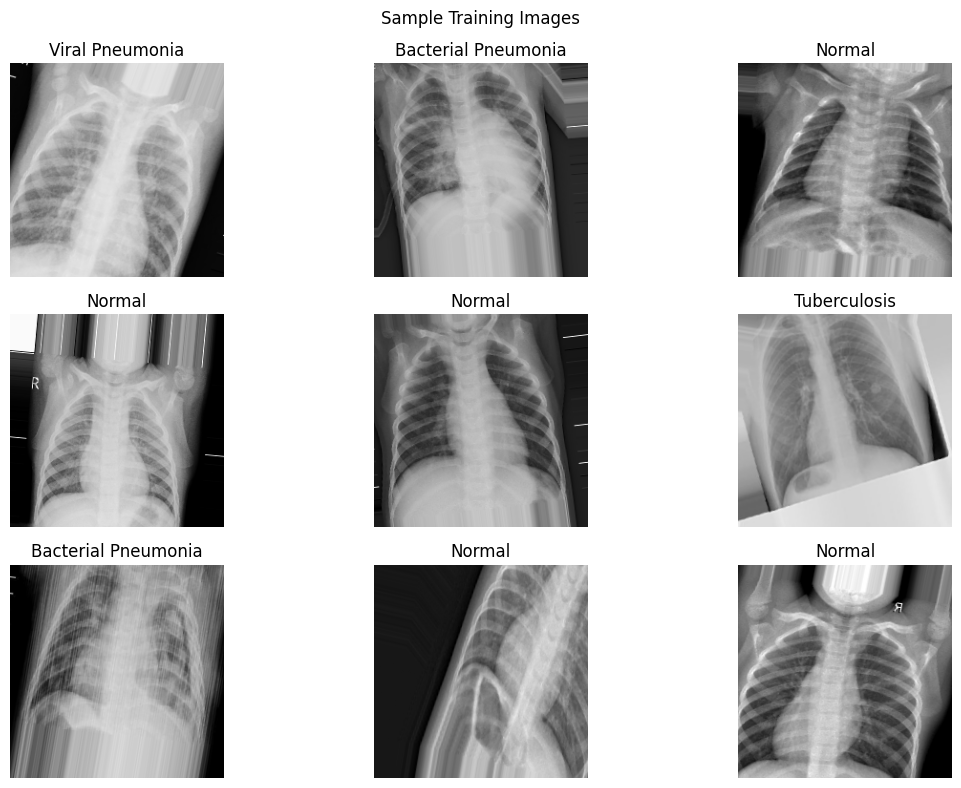

In [ ]:
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
print("Class names mapping:", class_indices)

def plot_sample_images(generator, title):
    plt.figure(figsize=(12, 8))
    batch = next(generator)
    for i in range(min(9, len(batch[0]))):
        plt.subplot(3, 3, i+1)
        image = batch[0][i]
        label = np.argmax(batch[1][i])
        plt.imshow(image)
        plt.title(f"{list(class_indices.keys())[label]}")
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_sample_images(train_generator, "Sample Training Images")

###**Step 10: Model Building - EfficientNet Architecture**

In [ ]:
def create_efficientnet_model():
    base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

    for layer in base_model.layers[:100]:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

### **Step 11: Define Ensemble Model (EfficientNet + DenseNet)**

In [ ]:
def create_ensemble_model():
    efficientnet_base = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

    for layer in efficientnet_base.layers[:100]:
        layer.trainable = False
    for layer in densenet_base.layers[:200]:
        layer.trainable = False

    input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    efficient_output = efficientnet_base(input_tensor)
    dense_output = densenet_base(input_tensor)

    efficient_pooled = GlobalAveragePooling2D()(efficient_output)
    dense_pooled = GlobalAveragePooling2D()(dense_output)

    concat = tf.keras.layers.Concatenate()([efficient_pooled, dense_pooled])

    x = BatchNormalization()(concat)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=predictions)

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

### **Step 12: Training Callbacks Setup**

In [ ]:
def get_callbacks():
    checkpoint = ModelCheckpoint(
        'lung_disease_model_best.h5',
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='max'
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        verbose=1,
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        verbose=1,
        min_lr=1e-6
    )

    return [checkpoint, early_stopping, reduce_lr]

### **Step 13: Model Training Function**

In [ ]:
def train_model():
    model = create_ensemble_model()  # Using ensemble for better performance

    model.summary()

    callbacks = get_callbacks()

    steps_per_epoch = train_generator.samples // BATCH_SIZE
    validation_steps = validation_generator.samples // BATCH_SIZE

    steps_per_epoch = max(1, steps_per_epoch)
    validation_steps = max(1, validation_steps)

    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_steps,
        callbacks=callbacks,
        verbose=1
    )

    return model, history

###**Step 14: Execute Model Training**

In [ ]:
print("Starting model training...")
model, history = train_model()
print("Training completed!")

Starting model training...
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb3      │ (None, 7, 7,      │ 10,783,535 │ input_layer_2[0]… │
│ (Functional)        │ 1536)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ densenet121         │ (None, 7, 7,      │  7,037,504 │ input_layer_2[0]… │
│ (Functional)        │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1536)      │          0 │ efficientnetb3[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1024)      │          0 │ densenet121[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2560)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 2560)      │     10,240 │ concatenate[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2560)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  1,311,232 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 5)         │      2,565 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,147,124 (73.04 MB)

 Trainable params: 16,673,867 (63.61 MB)

 Non-trainable params: 2,473,257 (9.43 MB)

Epoch 1/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5305 - loss: 1.5007
Epoch 1: val_accuracy improved from -inf to 0.74504, saving model to lung_disease_model_best.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 509s 2s/step - accuracy: 0.5311 - loss: 1.4988 - val_accuracy: 0.7450 - val_loss: 0.6497 - learning_rate: 1.0000e-04
Epoch 2/50
  1/189 ━━━━━━━━━━━━━━━━━━━━ 1:06 351ms/step - accuracy: 0.6250 - loss: 0.6765
Epoch 2: val_accuracy improved from 0.74504 to 0.74802, saving model to lung_disease_model_best.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.6250 - loss: 0.6765 - val_accuracy: 0.7480 - val_loss: 0.6467 - learning_rate: 1.0000e-04
Epoch 3/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - accuracy: 0.7562 - loss: 0.7352
Epoch 3: val_accuracy improved from 0.74802 to 0.82192, saving model to lung_disease_model_best.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 154s 814ms/step - accuracy: 0.7562 - loss: 0.7350 - val_accuracy: 0.8219 - val_loss: 0.4736 - learning_rate: 1.0000e-04
Epoch 4/50
  1/189 ━━━━━━━━━━━━━━━━━━━━ 1:02 335ms/step - accuracy: 0.7500 - loss: 0.8903
Epoch 4: val_accuracy improved from 0.82192 to 0.82242, saving model to lung_disease_model_best.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - accuracy: 0.7500 - loss: 0.8903 - val_accuracy: 0.8224 - val_loss: 0.4713 - learning_rate: 1.0000e-04
Epoch 5/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accuracy: 0.7835 - loss: 0.5934
Epoch 5: val_accuracy did not improve from 0.82242
189/189 ━━━━━━━━━━━━━━━━━━━━ 146s 770ms/step - accuracy: 0.7835 - loss: 0.5933 - val_accuracy: 0.8155 - val_loss: 0.5277 - learning_rate: 1.0000e-04
Epoch 6/50
  1/189 ━━━━━━━━━━━━━━━━━━━━ 50s 269ms/step - accuracy: 0.7188 - loss: 1.2233
Epoch 6: val_accuracy did not improve from 0.82242
189/189 ━━━━━━━━━━━━━━━━━━━━ 18s 96ms/step - accuracy: 0.7188 - loss: 1.2233 - val_accuracy: 0.8170 - val_loss: 0.5243 - learning_rate: 1.0000e-04
Epoch 7/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - accuracy: 0.8040 - loss: 0.5496
Epoch 7: val_accuracy improved from 0.82242 to 0.82887, saving model to lung_disease_model_best.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 147s 775ms/step - accuracy: 0.8040 - loss: 0.5494 - val_accuracy: 0.8289 - val_loss: 0.4859 - learning_rate: 1.0000e-04
Epoch 8/50
  1/189 ━━━━━━━━━━━━━━━━━━━━ 1:09 369ms/step - accuracy: 0.7188 - loss: 1.0809
Epoch 8: val_accuracy improved from 0.82887 to 0.83036, saving model to lung_disease_model_best.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 22s 114ms/step - accuracy: 0.7188 - loss: 1.0809 - val_accuracy: 0.8304 - val_loss: 0.4819 - learning_rate: 1.0000e-04
Epoch 9/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accuracy: 0.8339 - loss: 0.4556
Epoch 9: val_accuracy improved from 0.83036 to 0.87550, saving model to lung_disease_model_best.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 148s 782ms/step - accuracy: 0.8339 - loss: 0.4555 - val_accuracy: 0.8755 - val_loss: 0.3287 - learning_rate: 1.0000e-04
Epoch 10/50
  1/189 ━━━━━━━━━━━━━━━━━━━━ 1:06 356ms/step - accuracy: 0.7812 - loss: 0.5658
Epoch 10: val_accuracy improved from 0.87550 to 0.87599, saving model to lung_disease_model_best.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 21s 110ms/step - accuracy: 0.7812 - loss: 0.5658 - val_accuracy: 0.8760 - val_loss: 0.3290 - learning_rate: 1.0000e-04
Epoch 11/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - accuracy: 0.8367 - loss: 0.4408
Epoch 11: val_accuracy did not improve from 0.87599
189/189 ━━━━━━━━━━━━━━━━━━━━ 146s 772ms/step - accuracy: 0.8367 - loss: 0.4408 - val_accuracy: 0.8492 - val_loss: 0.4422 - learning_rate: 1.0000e-04
Epoch 12/50
  1/189 ━━━━━━━━━━━━━━━━━━━━ 50s 270ms/step - accuracy: 0.7500 - loss: 0.6632
Epoch 12: val_accuracy did not improve from 0.87599
189/189 ━━━━━━━━━━━━━━━━━━━━ 21s 109ms/step - accuracy: 0.7500 - loss: 0.6632 - val_accuracy: 0.8477 - val_loss: 0.4328 - learning_rate: 1.0000e-04
Epoch 13/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.8435 - loss: 0.3929
Epoch 13: val_accuracy did not improve from 0.87599
189/189 ━━━━━━━━━━━━━━━━━━━━ 147s 776ms/step - accuracy: 0.8436 - loss: 0.3929 - val_accuracy: 0.8616 - val_loss: 0.3700 - learning

189/189 ━━━━━━━━━━━━━━━━━━━━ 148s 783ms/step - accuracy: 0.8748 - loss: 0.3077 - val_accuracy: 0.8765 - val_loss: 0.3375 - learning_rate: 5.0000e-05
Epoch 18/50
  1/189 ━━━━━━━━━━━━━━━━━━━━ 1:06 354ms/step - accuracy: 0.8125 - loss: 0.4343
Epoch 18: val_accuracy improved from 0.87649 to 0.87698, saving model to lung_disease_model_best.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 21s 110ms/step - accuracy: 0.8125 - loss: 0.4343 - val_accuracy: 0.8770 - val_loss: 0.3372 - learning_rate: 5.0000e-05
Epoch 19/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - accuracy: 0.8726 - loss: 0.3184
Epoch 19: val_accuracy did not improve from 0.87698
189/189 ━━━━━━━━━━━━━━━━━━━━ 177s 761ms/step - accuracy: 0.8726 - loss: 0.3183 - val_accuracy: 0.8760 - val_loss: 0.3125 - learning_rate: 5.0000e-05
Epoch 20/50
  1/189 ━━━━━━━━━━━━━━━━━━━━ 51s 271ms/step - accuracy: 0.8438 - loss: 0.5312
Epoch 20: val_accuracy did not improve from 0.87698
189/189 ━━━━━━━━━━━━━━━━━━━━ 19s 97ms/step - accuracy: 0.8438 - loss: 0.5312 - val_accuracy: 0.8755 - val_loss: 0.3136 - learning_rate: 5.0000e-05
Epoch 21/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.8788 - loss: 0.2992
Epoch 21: val_accuracy improved from 0.87698 to 0.89534, saving model to lung_disease_model_best.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 148s 785ms/step - accuracy: 0.8788 - loss: 0.2992 - val_accuracy: 0.8953 - val_loss: 0.2744 - learning_rate: 5.0000e-05
Epoch 22/50
  1/189 ━━━━━━━━━━━━━━━━━━━━ 1:04 341ms/step - accuracy: 0.9062 - loss: 0.2762
Epoch 22: val_accuracy did not improve from 0.89534
189/189 ━━━━━━━━━━━━━━━━━━━━ 18s 95ms/step - accuracy: 0.9062 - loss: 0.2762 - val_accuracy: 0.8943 - val_loss: 0.2750 - learning_rate: 5.0000e-05
Epoch 23/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.8930 - loss: 0.2628
Epoch 23: val_accuracy did not improve from 0.89534
189/189 ━━━━━━━━━━━━━━━━━━━━ 179s 760ms/step - accuracy: 0.8930 - loss: 0.2629 - val_accuracy: 0.8750 - val_loss: 0.3302 - learning_rate: 5.0000e-05
Epoch 24/50
  1/189 ━━━━━━━━━━━━━━━━━━━━ 50s 270ms/step - accuracy: 0.9375 - loss: 0.1668
Epoch 24: val_accuracy did not improve from 0.89534
189/189 ━━━━━━━━━━━━━━━━━━━━ 19s 98ms/step - accuracy: 0.9375 - loss: 0.1668 - val_accuracy: 0.8760 - val_loss: 0.3295 - learning

###**Step 15: Training History Visualization**

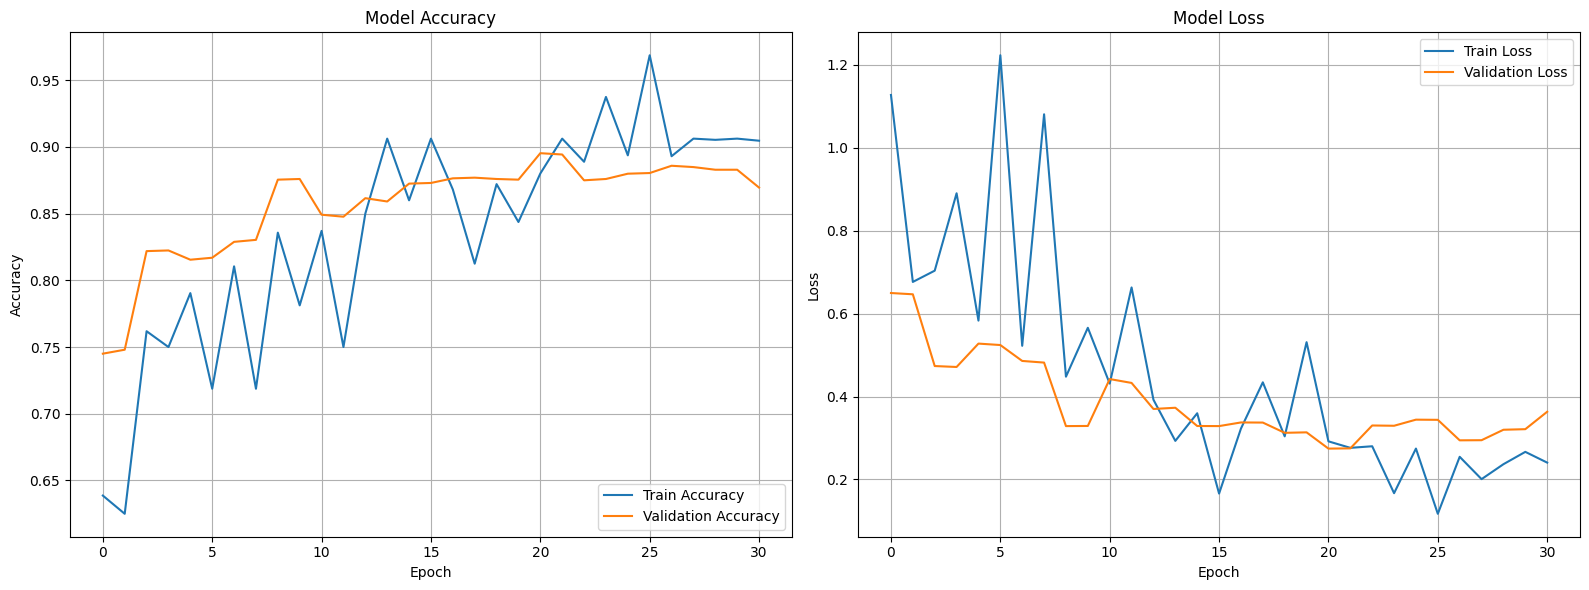

In [ ]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc='lower right')
    ax1.grid(True)

    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='upper right')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

###**Step 16: Model Evaluation on Test Data**

Evaluating model on test data...
64/64 ━━━━━━━━━━━━━━━━━━━━ 75s 732ms/step
Test Accuracy: 0.8998
Test Precision: 0.8984
Test Recall: 0.8998
Test F1 Score: 0.8987


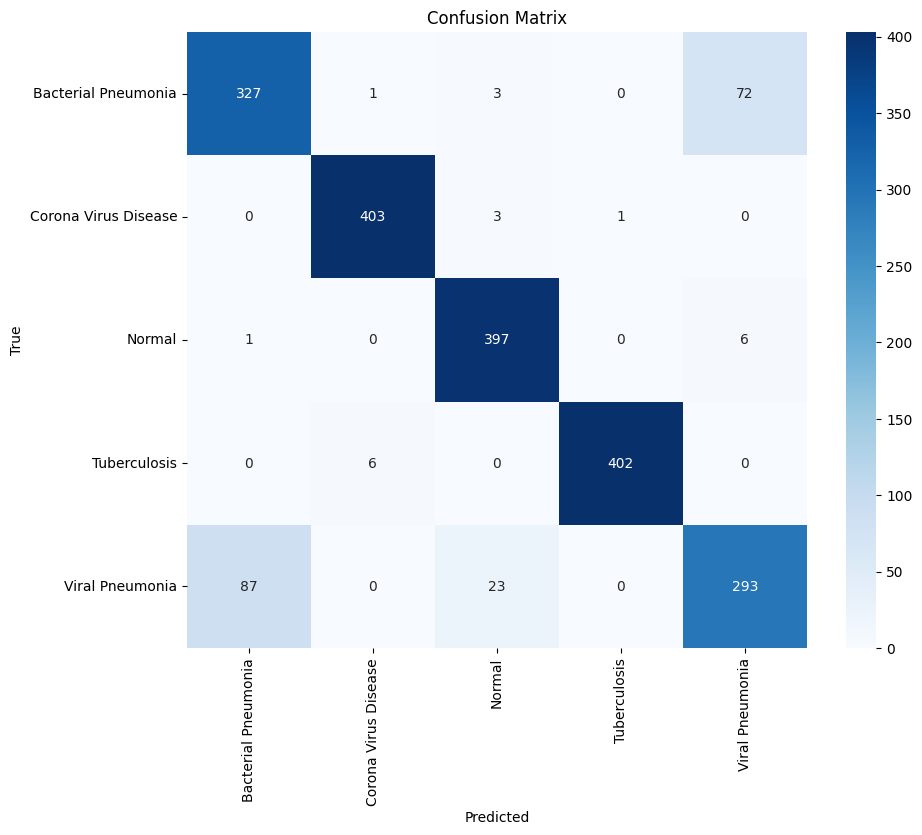

Classification Report:
                      precision    recall  f1-score   support

 Bacterial Pneumonia       0.79      0.81      0.80       403
Corona Virus Disease       0.98      0.99      0.99       407
              Normal       0.93      0.98      0.96       404
        Tuberculosis       1.00      0.99      0.99       408
     Viral Pneumonia       0.79      0.73      0.76       403

            accuracy                           0.90      2025
           macro avg       0.90      0.90      0.90      2025
        weighted avg       0.90      0.90      0.90      2025



In [ ]:
def evaluate_model(model, test_generator):
    steps = np.ceil(test_generator.samples / BATCH_SIZE).astype(int)

    test_generator.reset()
    y_pred_probs = model.predict(test_generator, steps=steps)
    y_pred = np.argmax(y_pred_probs, axis=1)

    y_true = test_generator.classes[:len(y_pred)]

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1 Score: {f1:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    report = classification_report(y_true, y_pred, target_names=class_names)
    print("Classification Report:")
    print(report)

    return accuracy, precision, recall, f1

print("Evaluating model on test data...")
accuracy, precision, recall, f1 = evaluate_model(model, test_generator)

###**Step 17: Fine-Tuning (Conditional Execution)**

Metrics below target threshold of 95%. Applying fine-tuning...
Epoch 1/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8965 - loss: 0.2590
Epoch 1: val_accuracy improved from -inf to 0.87996, saving model to lung_disease_model_best.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 515s 2s/step - accuracy: 0.8965 - loss: 0.2590 - val_accuracy: 0.8800 - val_loss: 0.3214 - learning_rate: 1.0000e-05
Epoch 2/20
  1/189 ━━━━━━━━━━━━━━━━━━━━ 1:11 382ms/step - accuracy: 0.9062 - loss: 0.1646
Epoch 2: val_accuracy did not improve from 0.87996
189/189 ━━━━━━━━━━━━━━━━━━━━ 19s 98ms/step - accuracy: 0.9062 - loss: 0.1646 - val_accuracy: 0.8800 - val_loss: 0.3221 - learning_rate: 1.0000e-05
Epoch 3/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 794ms/step - accuracy: 0.8893 - loss: 0.2714
Epoch 3: val_accuracy did not improve from 0.87996
189/189 ━━━━━━━━━━━━━━━━━━━━ 173s 902ms/step - accuracy: 0.8893 - loss: 0.2714 - val_accuracy: 0.8795 - val_loss: 0.3252 - learning_rate: 1.0000e-05
Epoch 4/20
  1/189 ━━━━━━━━━━━━━━━━━━━━ 49s 266ms/step - accuracy: 0.9062 - loss: 0.3281
Epoch 4: val_accuracy did not improve from 0.87996
189/189 ━━━━━━━━━━━━━━━━━━━━ 21s 109ms/step - accuracy: 0.9062 - loss: 0.3281 - val_accuracy: 0.8800 - val_loss: 0.3250 - learning_rate: 1

189/189 ━━━━━━━━━━━━━━━━━━━━ 183s 913ms/step - accuracy: 0.8956 - loss: 0.2537 - val_accuracy: 0.8805 - val_loss: 0.3263 - learning_rate: 1.0000e-05
Epoch 6/20
  1/189 ━━━━━━━━━━━━━━━━━━━━ 1:06 353ms/step - accuracy: 0.9062 - loss: 0.1970
Epoch 6: val_accuracy improved from 0.88046 to 0.88095, saving model to lung_disease_model_best.h5



Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
189/189 ━━━━━━━━━━━━━━━━━━━━ 22s 116ms/step - accuracy: 0.9062 - loss: 0.1970 - val_accuracy: 0.8810 - val_loss: 0.3272 - learning_rate: 1.0000e-05
Epoch 7/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 725ms/step - accuracy: 0.8934 - loss: 0.2557
Epoch 7: val_accuracy did not improve from 0.88095
189/189 ━━━━━━━━━━━━━━━━━━━━ 157s 833ms/step - accuracy: 0.8934 - loss: 0.2557 - val_accuracy: 0.8790 - val_loss: 0.3201 - learning_rate: 5.0000e-06
Epoch 8/20
  1/189 ━━━━━━━━━━━━━━━━━━━━ 51s 271ms/step - accuracy: 0.8125 - loss: 0.3800
Epoch 8: val_accuracy did not improve from 0.88095
189/189 ━━━━━━━━━━━━━━━━━━━━ 19s 101ms/step - accuracy: 0.8125 - loss: 0.3800 - val_accuracy: 0.8785 - val_loss: 0.3202 - learning_rate: 5.0000e-06
Epoch 9/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.8895 - loss: 0.2613
Epoch 9: val_accuracy improved from 0.88095 to 0.88145, saving model to lung_disease_model_best.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 156s 824ms/step - accuracy: 0.8895 - loss: 0.2613 - val_accuracy: 0.8814 - val_loss: 0.3151 - learning_rate: 5.0000e-06
Epoch 10/20
  1/189 ━━━━━━━━━━━━━━━━━━━━ 1:06 354ms/step - accuracy: 0.8438 - loss: 0.2652
Epoch 10: val_accuracy did not improve from 0.88145
189/189 ━━━━━━━━━━━━━━━━━━━━ 20s 103ms/step - accuracy: 0.8438 - loss: 0.2652 - val_accuracy: 0.8814 - val_loss: 0.3149 - learning_rate: 5.0000e-06
Epoch 11/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 700ms/step - accuracy: 0.8980 - loss: 0.2524
Epoch 11: val_accuracy improved from 0.88145 to 0.88492, saving model to lung_disease_model_best.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 185s 841ms/step - accuracy: 0.8980 - loss: 0.2524 - val_accuracy: 0.8849 - val_loss: 0.3034 - learning_rate: 5.0000e-06
Epoch 12/20
  1/189 ━━━━━━━━━━━━━━━━━━━━ 1:05 347ms/step - accuracy: 0.8750 - loss: 0.2708
Epoch 12: val_accuracy did not improve from 0.88492
189/189 ━━━━━━━━━━━━━━━━━━━━ 20s 104ms/step - accuracy: 0.8750 - loss: 0.2708 - val_accuracy: 0.8844 - val_loss: 0.3037 - learning_rate: 5.0000e-06
Epoch 13/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9022 - loss: 0.2425
Epoch 13: val_accuracy did not improve from 0.88492
189/189 ━━━━━━━━━━━━━━━━━━━━ 176s 807ms/step - accuracy: 0.9022 - loss: 0.2425 - val_accuracy: 0.8844 - val_loss: 0.3072 - learning_rate: 5.0000e-06
Epoch 14/20
  1/189 ━━━━━━━━━━━━━━━━━━━━ 50s 271ms/step - accuracy: 0.8750 - loss: 0.2824
Epoch 14: val_accuracy did not improve from 0.88492
189/189 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - accuracy: 0.8750 - loss: 0.2824 - val_accuracy: 0.8844 - val_loss: 0.3071 - learni

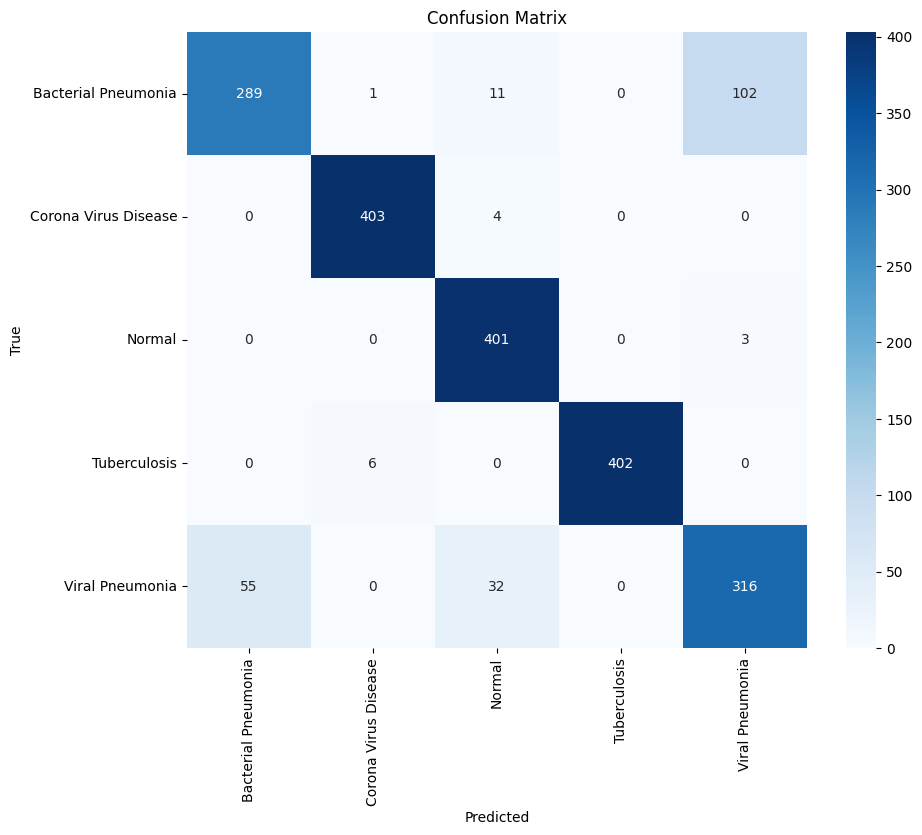

Classification Report:
                      precision    recall  f1-score   support

 Bacterial Pneumonia       0.84      0.72      0.77       403
Corona Virus Disease       0.98      0.99      0.99       407
              Normal       0.90      0.99      0.94       404
        Tuberculosis       1.00      0.99      0.99       408
     Viral Pneumonia       0.75      0.78      0.77       403

            accuracy                           0.89      2025
           macro avg       0.89      0.89      0.89      2025
        weighted avg       0.89      0.89      0.89      2025



In [ ]:
if any(metric < 0.95 for metric in [accuracy, precision, recall, f1]):
    print("Metrics below target threshold of 95%. Applying fine-tuning...")

    for layer in model.layers:
        layer.trainable = True

    model.compile(
        optimizer=Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    steps_per_epoch = train_generator.samples // BATCH_SIZE
    validation_steps = validation_generator.samples // BATCH_SIZE

    steps_per_epoch = max(1, steps_per_epoch)
    validation_steps = max(1, validation_steps)

    fine_tune_history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=20,
        validation_data=validation_generator,
        validation_steps=validation_steps,
        callbacks=get_callbacks(),
        verbose=1
    )

    print("\nAfter fine-tuning:")
    accuracy, precision, recall, f1 = evaluate_model(model, test_generator)

###**Step 18: Prediction Function for Single Images**

In [ ]:
from tensorflow.keras.preprocessing import image

def predict_single_image(image_path, model):
    img = image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    predicted_class_name = list(class_indices.keys())[list(class_indices.values()).index(predicted_class)]
    confidence = float(prediction[0][predicted_class])

    print(f"Predicted class: {predicted_class_name}")
    print(f"Confidence: {confidence:.4f}")

    plt.imshow(img)
    plt.title(f"Prediction: {predicted_class_name} ({confidence:.4f})")
    plt.axis('off')
    plt.show()

    return predicted_class_name, confidence

###**Step 19: Save Final Model**

In [ ]:
model.save('lung_disease_classification_final_model.h5')
print("Model saved successfully!")

Model saved successfully!


###**Step 20: Test Predictions Visualization**

Visualizing test predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step


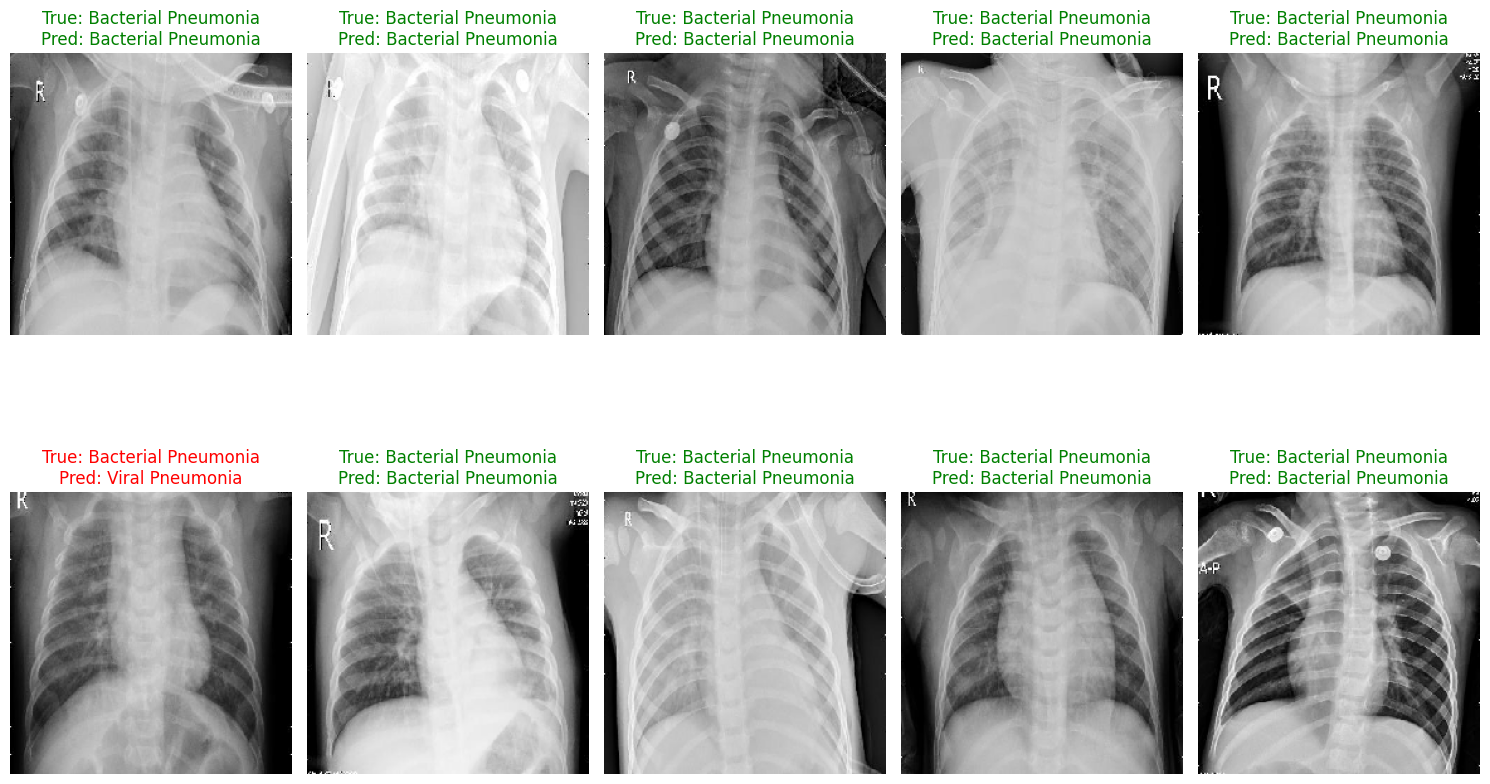

In [ ]:
def visualize_test_predictions(model, test_generator, num_samples=10):
    test_generator.reset()
    batch = next(test_generator)

    test_images = batch[0]
    test_labels = batch[1]

    predictions = model.predict(test_images)

    plt.figure(figsize=(15, 10))
    for i in range(min(num_samples, len(test_images))):
        plt.subplot(2, 5, i+1)
        plt.imshow(test_images[i])
        true_class_idx = np.argmax(test_labels[i])
        pred_class_idx = np.argmax(predictions[i])

        true_class_name = list(class_indices.keys())[list(class_indices.values()).index(true_class_idx)]
        pred_class_name = list(class_indices.keys())[list(class_indices.values()).index(pred_class_idx)]

        if true_class_idx == pred_class_idx:
            title_color = 'green'
        else:
            title_color = 'red'

        plt.title(f"True: {true_class_name}\nPred: {pred_class_name}", color=title_color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

print("Visualizing test predictions...")
visualize_test_predictions(model, test_generator)

###**Step 21: Final Results Summary**

In [ ]:
print("\nFinal Metrics Summary:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Final Metrics Summary:
Accuracy: 0.8943
Precision: 0.8942
Recall: 0.8943
F1 Score: 0.8927
